In [74]:
import pandas as pd

data = pd.read_parquet("../data/dataset/reddit+shsyt/data.parquet").drop_duplicates(subset="id")
data["yt_id"] = data.id.apply(lambda x: x.split("_", 1)[1])

data["has_WoA"] = data.IOB.apply(lambda x: "B-WoA" in x)
data["has_Artist"] = data.IOB.apply(lambda x: "B-Artist" in x)

data_shs = pd.read_json("../data/raw/shs100k_metadata.jsonl", lines=True, orient="records")
data_shs = data_shs[['work_id', 'perf_id','perf_title', 'perf_artist']]
data_shs.columns = pd.MultiIndex.from_product([[''], data_shs.columns])

In [75]:
from typing import List
import sys
sys.path.append("../preprocessing")
from Processor import PerformerStringPreprocessor
from Utils import simplify_string, remove_bracket_with_one_content


def get_title_variations(s: str) -> List[str]:
    s = remove_bracket_with_one_content(s)
    l = s.split("/")
    l = [simplify_string(s) for s in l]
    return l

performer_processor = PerformerStringPreprocessor()

def get_performer_variations(s: str) -> List[str]:
    l = performer_processor.split_performers(s)
    l = [simplify_string(s) for s in l]
    l = performer_processor.article_preprocessing(l)
    return l

get_performer_variations("quentin tarantino feat. steven spielberg")


['quentin tarantino', 'steven spielberg']

# Factual Memorization

In [76]:
import pandas as pd
import ast

_ = pd.read_json("../data/intermediate/shs100k2_memorization.jsonl", lines=True, orient="records")

cols = []
for c in _.columns:
    new_c = ast.literal_eval(c)
    if new_c[1] == '':
        new_c = (new_c[1], new_c[0])
    cols.append(new_c)

_.columns = pd.MultiIndex.from_tuples(cols, names=["Model", ""])
_ = pd.merge(_, data_shs, 
                             how="left", on=[("", "work_id"), ("", "perf_id")])
# _ = _[[c for c in _.columns if "AW2" not in c[1]]]
_.columns = [(c[0], c[1].replace("AW3:", "AW2:")) for c in _.columns]
_ = _
_.columns = pd.MultiIndex.from_tuples(_.columns, names=["Model", ""])


In [77]:
models = []

for c in _.columns:
    model = c[0]
    if model != '' and model not in models:
        models.append(model)

        __ = _[model]

        _aw_cols = [c for c in __.columns if c.startswith("AW")]
        _aw_cols_related = [c for c in _aw_cols if "Related" in c]
        _aw_cols_correct = [c for c in _aw_cols if "Correct" in c]

        def correctness(row):
            if row[_aw_cols].T.sum() == 0:
                return "test_failed"
            elif row[_aw_cols_correct].T.sum() >= 2:
                return "test_passed"
            elif row[_aw_cols_correct].T.sum() == 0 and row[_aw_cols_related].T.sum() > 0:
                return "test_min1_partly"
            elif row[_aw_cols_correct].T.sum() > 0:
                return "test_min1"
            
        _[(model, "Correctness")] = __.apply(correctness, axis=1)
        _[(model, "Correctness")].value_counts()

__ = _[[("", "set_id")] + [(model, "Correctness") for model in models]]
__.columns = ["set_id"] + [f"{model}_Correctness" for model in models]
data_memorization = pd.merge(data, __, on="set_id", how="left")
data_memorization#.Correctness.value_counts()



,id,set_id,Origin,TEXT,IOB,subset,yt_id,has_WoA,has_Artist,Llama3.1-70B_Correctness,Llama3.1-8B_Correctness
0,21_L1-t3YvFH40,21.0,YouTube,"[gladys, knight, &, the, pips, -, yesterday]","[B-Artist, I-Artist, O, B-Artist, I-Artist, O,...",4,L1-t3YvFH40,True,True,test_passed,test_passed
1,21_L1-t3YvFH40,21.0,YouTube,"[gladys, knight, &, the, pips, -, yesterday]","[B-Artist, I-Artist, O, B-Artist, I-Artist, O,...",4,L1-t3YvFH40,True,True,test_min1,test_min1
2,21_4SE8UvqaSWQ,21.0,YouTube,"[hooked, on, the, beatles, -, the, end]","[B-WoA, I-WoA, I-WoA, I-WoA, O, B-WoA, I-WoA]",4,4SE8UvqaSWQ,True,False,test_passed,test_passed
3,21_4SE8UvqaSWQ,21.0,YouTube,"[hooked, on, the, beatles, -, the, end]","[B-WoA, I-WoA, I-WoA, I-WoA, O, B-WoA, I-WoA]",4,4SE8UvqaSWQ,True,False,test_min1,test_min1
4,58_hQz-aZH-ozU,58.0,YouTube,"[juan, rozoff, -, plaisir, d, amour]","[B-Artist, I-Artist, O, B-WoA, I-WoA, I-WoA]",1,hQz-aZH-ozU,True,True,test_min1_partly,test_min1
...,...,...,...,...,...,...,...,...,...,...,...
3302,dataset4_746,12669.0,Reddit,"[songs, like, sub, urbams, cradle, ?]","[O, O, B-Artist, I-Artist, B-WoA, O]",5,746,True,True,NaN,NaN
3303,dataset4_747,12670.0,Reddit,"[songs, /, artists, like, quarter, past, midni...","[O, O, O, O, B-WoA, I-WoA, I-WoA, O, B-Artist]",1,747,True,True,NaN,NaN
3304,dataset4_748,12671.0,Reddit,"[soft, -, voiced, vocals]","[O, O, O, O]",2,748,False,False,NaN,NaN
3305,dataset4_749,12672.0,Reddit,"[find, me, music, with, dark, lyrics, covered,...","[O, O, O, O, O, O, O, O, O, O, O, O, O]",3,749,False,False,NaN,NaN


In [87]:
pd.read_parquet("../data/dataset/reddit+shsyt/data.parquet")


,id,set_id,Origin,TEXT,IOB,subset
46,21_L1-t3YvFH40,21.0,YouTube,"[gladys, knight, &, the, pips, -, yesterday]","[B-Artist, I-Artist, O, B-Artist, I-Artist, O,...",4
79,21_4SE8UvqaSWQ,21.0,YouTube,"[hooked, on, the, beatles, -, the, end]","[B-WoA, I-WoA, I-WoA, I-WoA, O, B-WoA, I-WoA]",4
170,58_hQz-aZH-ozU,58.0,YouTube,"[juan, rozoff, -, plaisir, d, amour]","[B-Artist, I-Artist, O, B-WoA, I-WoA, I-WoA]",1
219,58_Ajp0Uaw4rqo,58.0,YouTube,"[ub40, cant, help, falling, in, love]","[B-Artist, B-WoA, I-WoA, I-WoA, I-WoA, I-WoA]",1
224,58_m3MXZ_qdKDU,58.0,YouTube,"[pearl, jam, -, i, cant, help, falling, in, lo...","[B-Artist, I-Artist, O, B-WoA, I-WoA, I-WoA, I...",1
...,...,...,...,...,...,...
2676,dataset4_746,12669.0,Reddit,"[songs, like, sub, urbams, cradle, ?]","[O, O, B-Artist, I-Artist, B-WoA, O]",5
2677,dataset4_747,12670.0,Reddit,"[songs, /, artists, like, quarter, past, midni...","[O, O, O, O, B-WoA, I-WoA, I-WoA, O, B-Artist]",1
2678,dataset4_748,12671.0,Reddit,"[soft, -, voiced, vocals]","[O, O, O, O]",2
2679,dataset4_749,12672.0,Reddit,"[find, me, music, with, dark, lyrics, covered,...","[O, O, O, O, O, O, O, O, O, O, O, O, O]",3


,id,set_id,Origin,TEXT,IOB,subset,yt_id,has_WoA,has_Artist,Llama3.1-70B_Correctness,Llama3.1-8B_Correctness
0,21_L1-t3YvFH40,21.0,YouTube,"[gladys, knight, &, the, pips, -, yesterday]","[B-Artist, I-Artist, O, B-Artist, I-Artist, O,...",4,L1-t3YvFH40,True,True,test_passed,test_passed
1,21_L1-t3YvFH40,21.0,YouTube,"[gladys, knight, &, the, pips, -, yesterday]","[B-Artist, I-Artist, O, B-Artist, I-Artist, O,...",4,L1-t3YvFH40,True,True,test_min1,test_min1
2,21_4SE8UvqaSWQ,21.0,YouTube,"[hooked, on, the, beatles, -, the, end]","[B-WoA, I-WoA, I-WoA, I-WoA, O, B-WoA, I-WoA]",4,4SE8UvqaSWQ,True,False,test_passed,test_passed
3,21_4SE8UvqaSWQ,21.0,YouTube,"[hooked, on, the, beatles, -, the, end]","[B-WoA, I-WoA, I-WoA, I-WoA, O, B-WoA, I-WoA]",4,4SE8UvqaSWQ,True,False,test_min1,test_min1
4,58_hQz-aZH-ozU,58.0,YouTube,"[juan, rozoff, -, plaisir, d, amour]","[B-Artist, I-Artist, O, B-WoA, I-WoA, I-WoA]",1,hQz-aZH-ozU,True,True,test_min1_partly,test_min1
...,...,...,...,...,...,...,...,...,...,...,...
3302,dataset4_746,12669.0,Reddit,"[songs, like, sub, urbams, cradle, ?]","[O, O, B-Artist, I-Artist, B-WoA, O]",5,746,True,True,NaN,NaN
3303,dataset4_747,12670.0,Reddit,"[songs, /, artists, like, quarter, past, midni...","[O, O, O, O, B-WoA, I-WoA, I-WoA, O, B-Artist]",1,747,True,True,NaN,NaN
3304,dataset4_748,12671.0,Reddit,"[soft, -, voiced, vocals]","[O, O, O, O]",2,748,False,False,NaN,NaN
3305,dataset4_749,12672.0,Reddit,"[find, me, music, with, dark, lyrics, covered,...","[O, O, O, O, O, O, O, O, O, O, O, O, O]",3,749,False,False,NaN,NaN


# Exposure

In [ ]:
_ = pd.read_json("../data/intermediate/shs100k2_exposure.jsonl", lines=True, orient="records")

__ = pd.read_parquet("../data/raw/shs100k2_yt.parquet")[["set_id", "yt_id", "title", "performer"]]
__.title = __.title.str.lower()
__.performer = __.performer.str.lower()

_map = __.set_index(["set_id", "yt_id"]).to_dict()
data["title"] = data.apply(lambda x: _map["title"].get((x.set_id, x.yt_id)), axis=1)
data["performer"] = data.apply(lambda x: _map["performer"].get((x.set_id, x.yt_id)), axis=1)


data_exposure = pd.concat(
    [pd.merge(
        data, 
        _.loc[_.Entity == "WoA"], 
        left_on=["set_id", "title"], 
        right_on=["set_id", "name"],
        how="left"),
     pd.merge(
         data, 
         _.loc[_.Entity == "Artist"], 
         left_on=["set_id", "performer"], 
         right_on=["set_id", "name"], 
         how="left")]
).drop("yt_id_y", axis=1).rename(columns={"yt_id_x": "yt_id"}).drop_duplicates(subset=["id", "Entity"])
data_exposure


/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


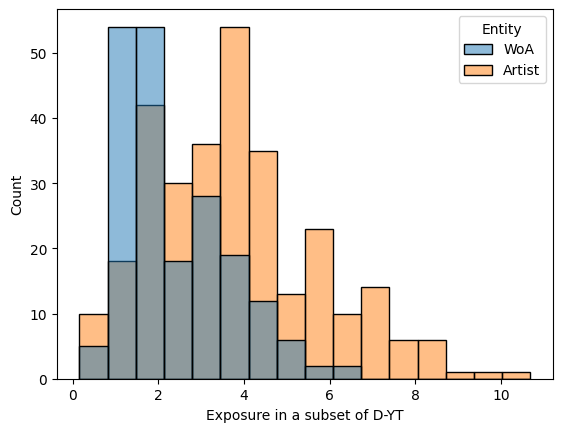

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data_exposure.dropna(subset="exposure_max"), x="exposure_max", hue="Entity")
plt.xlabel("Exposure in a subset of D-YT")
plt.savefig("../figures/hist_exposure_dataset.pdf")
plt.show()
